# GAN. DCGAN, Keras, MNIST

## Standard GAN Keras

In [1]:
import keras
import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\toem\anaconda2\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

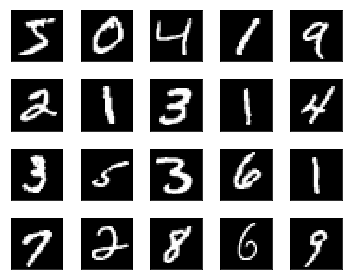

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

### Generator

In [4]:
def make_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [5]:
arr = make_latent_samples(1, 100)
print(arr.shape)
print(arr[0, 1:10])


(1, 100)
[-1.71414653  0.24878817 -0.65636874  0.23533022 -1.2499107   0.10409382
  1.23764056 -0.96946626 -0.37797538]


In [9]:
generator = Sequential([
    Dense(128, input_shape=(100, )),
    LeakyReLU(alpha=0.01),
    Dense(784),
    Activation("tanh")
], name="generator")

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_3 (Activation)    (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


### Discriminator

In [10]:
discriminator = Sequential([
    Dense(128, input_shape=(784, )),
    LeakyReLU(alpha=0.01),
    Dense(1),
    Activation("sigmoid")
], name="discriminator")

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [11]:
gan = Sequential({
    generator, 
    discriminator
})

gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 784)               114064    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 214,673
Non-trainable params: 0
_________________________________________________________________


In [12]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [13]:
make_trainable(discriminator, False)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 0
Non-trainable params: 100,609
_________________________________________________________________


In [14]:
make_trainable(discriminator, True)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [23]:
def make_simple_gan(sample_size,
                   gen_hidden_size,
                   disc_hidden_size,
                   leaky_alpha,
                   g_lr,
                   d_lr):
    
    K.clear_session()
    
    generator = Sequential([
        Dense(gen_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),
        Activation("tanh")
    ], name="generator")
    
    discriminator = Sequential([
        Dense(disc_hidden_size, input_shape=(784, )),
        LeakyReLU(leaky_alpha),
        Dense(1),
        Activation("sigmoid")
    ], name="discriminator")
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(d_lr), loss="binary_crossentropy")
    gan.compile(optimizer=Adam(g_lr), loss="binary_crossentropy")
    
    return gan, generator, discriminator
    

### Training GAN

In [24]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [25]:
print(X_train_real.shape)

(60000, 784)


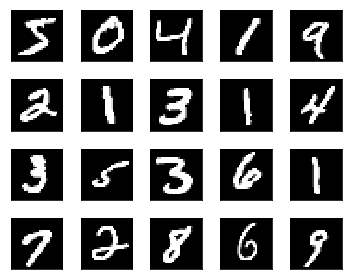

In [26]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(X_train_real[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [27]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [28]:
y_real_10, y_fake_10 = make_labels(10)

In [29]:
print(y_fake_10)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [30]:
# hyperparams
sample_size = 100
g_hidden_size = 128
d_hidden_size = 128
leaky_alpha = 0.01
g_lr = 0.0001
d_lr = 0.001
epochs = 20
batchsize = 64
eval_size = 16
smooth = 0.1

y_train_real, y_train_fake = make_labels(batchsize)
y_eval_real, y_eval_fake = make_labels(eval_size)

gan, generator, discriminator = make_simple_gan(
    sample_size, 
    g_hidden_size, 
    d_hidden_size,
    leaky_alpha,
    g_lr,
    d_lr)

In [34]:
losses = []

for epoch in range(epochs):
    for i in range(len(X_train_real)//batchsize):
        
        # batch mnist reale images
        X_batch_real = X_train_real[i*batchsize:(i+1)*batchsize]
        
        # latent samples
        latent_samples = make_latent_samples(batchsize, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train discriminator
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)
        
        # train generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
        
    # eval after 1 epoch
    
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)
    
    d_loss = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    
    g_loss = gan.test_on_batch(latent_samples, y_eval_real)
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(epoch+1, epochs, d_loss, g_loss))
        
        
        
        

c:\users\toem\anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/20 Discriminator Loss: 0.2051 Generator Loss: 5.6709
Epoch:   2/20 Discriminator Loss: 0.2907 Generator Loss: 3.6810
Epoch:   3/20 Discriminator Loss: 0.9380 Generator Loss: 6.2562
Epoch:   4/20 Discriminator Loss: 0.2278 Generator Loss: 3.7115
Epoch:   5/20 Discriminator Loss: 0.3957 Generator Loss: 3.3117
Epoch:   6/20 Discriminator Loss: 0.5483 Generator Loss: 4.0403
Epoch:   7/20 Discriminator Loss: 0.5061 Generator Loss: 4.1072
Epoch:   8/20 Discriminator Loss: 0.4527 Generator Loss: 4.7154
Epoch:   9/20 Discriminator Loss: 0.3367 Generator Loss: 3.6500
Epoch:  10/20 Discriminator Loss: 0.9129 Generator Loss: 4.8293
Epoch:  11/20 Discriminator Loss: 0.5064 Generator Loss: 3.1362
Epoch:  12/20 Discriminator Loss: 0.2123 Generator Loss: 4.0740
Epoch:  13/20 Discriminator Loss: 0.2940 Generator Loss: 4.0577
Epoch:  14/20 Discriminator Loss: 0.3213 Generator Loss: 2.9419
Epoch:  15/20 Discriminator Loss: 0.3688 Generator Loss: 5.8565
Epoch:  16/20 Discriminator Loss: 0.3916

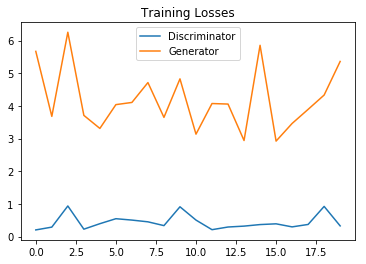

In [36]:

losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

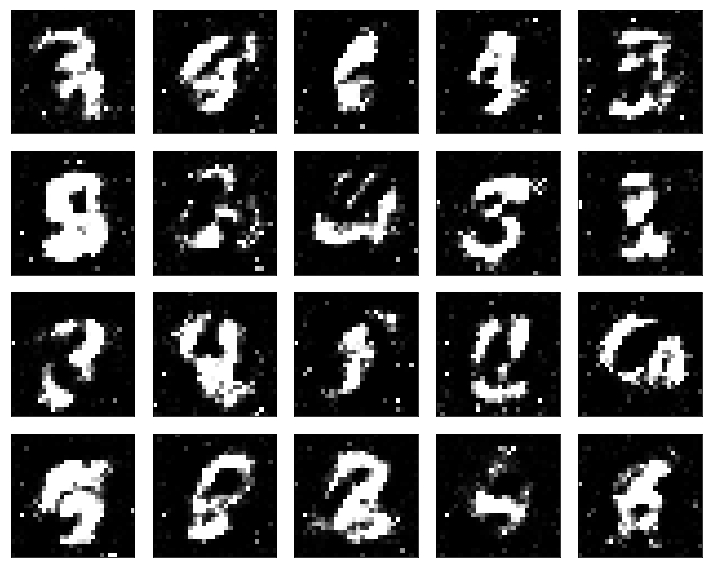

In [37]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()